# Amazon review

In [44]:
#load library
import json
from pandas.io.json import json_normalize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


%matplotlib inline

# set seed for reproducibility
np.random.seed(0)

# read in all our data
digital_music = pd.read_json('Digital_Music_5.json', lines=True)

In [45]:
pd.set_option('display.max_columns', None)

In [46]:
#digital_music.sample(n=10, random_state=50)

In [47]:
digital_music.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,5555991584,"[3, 3]",5,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200
1,5555991584,"[0, 0]",5,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400
2,5555991584,"[2, 2]",5,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800
3,5555991584,"[1, 1]",5,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000
4,5555991584,"[1, 1]",4,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000


In [48]:
digital_music.tail()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
64701,B00KILDVEI,"[0, 0]",4,I like the reggae sound a lot in this song. I ...,"06 24, 2014",A1PQ1PESSO8CMO,Ginger Christmas,Cool song,1403568000
64702,B00KILDVEI,"[0, 0]",5,I first heard this on Sirius and had to have i...,"07 9, 2014",A120RH58WVY4W6,"Kelly Dunwell ""avid reader""",Great Song,1404864000
64703,B00KILDVEI,"[0, 1]",5,"I absolutely love this song, it downloaded fin...","07 13, 2014",A19VJ2IQLO50G0,melinda,Five Stars,1405209600
64704,B00KILDVEI,"[0, 0]",3,"Reggae, island beats aren't really my cup of t...","07 9, 2014",AUDSM2CTLLW1Q,Patrick L. Randall,Well-crafted song,1404864000
64705,B00KILDVEI,"[1, 2]",1,Magic! is a Canadian band that incorporates re...,"07 18, 2014",A1GN8UJIZLCA59,P Magnum,Souless Reggae,1405641600


In [49]:
#Xem số dòng, số cột của dataframe
digital_music.shape

(64706, 9)

In [50]:
digital_music.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime'],
      dtype='object')

In [51]:
# Số lượng điểm data bị thiếu trên mỗi cột
missing_values_count = digital_music.isnull().sum()

# Số lượng điểm data bị thiếu trên mỗi cột của 10 cột đầu
missing_values_count

asin                0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      177
summary             0
unixReviewTime      0
dtype: int64

<b>Nhận Xét:</b> Dữ liệu đẹp nên không cần phải xử lý missing value nữa

<b>Nhận Xét:</b> Chuyển overall có giá trị 1, 2: 1(negative); 3: 2(neutral); 4, 5: 3(positive)

In [52]:
def format_target_value(row):
    data = row.overall
    val = 0
    if data <= 2:
        val = 1
    elif data > 3:
        val = 3
    else:
        val = 2
    row['target'] = val
    return row
digital_music = digital_music.apply(format_target_value, axis=1)

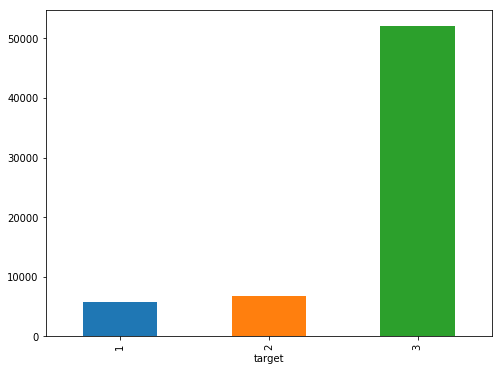

In [53]:
fig = plt.figure(figsize=(8,6))
digital_music.groupby('target').reviewText.count().plot.bar(ylim=0)
plt.show()

<b>Nhận Xét: </b>Dữ liệu không cân bằng giữa target = 3 với target = 1 hoặc 2. Ta sẽ đi train model với 2 trường hợp: 1 là dữ liệu với class imbalance. 2 là dữ liệu với class balance

In [54]:
def cv_accuracy(feature, target):
    models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
                LinearSVC(),
                MultinomialNB(),
                LogisticRegression(random_state=0)]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, feature, target, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    return cv_df

In [55]:
def display_cv_df(cv_df):
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()

In [56]:
vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf =True, lowercase=True, strip_accents='ascii', stop_words = 'english')

# Class balance

In [57]:
digital_music['target'].value_counts()

3    52116
2     6789
1     5801
Name: target, dtype: int64

In [58]:
digital_music_pos = digital_music[digital_music['target'] == 3].sample(n=6000, random_state=50)
digital_music_neutral = digital_music[digital_music['target'] == 2]
digital_music_neg = digital_music[digital_music['target'] == 1]

In [59]:
digital_music_pos['target'].value_counts()

3    6000
Name: target, dtype: int64

In [60]:
digital_music_with_class_balance = digital_music_pos.append(digital_music_neutral).append(digital_music_neg);

In [61]:
digital_music_with_class_balance.shape

(18590, 10)

In [62]:
digital_music_with_class_balance.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'target'],
      dtype='object')

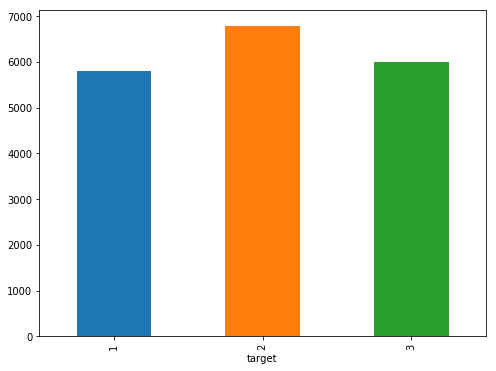

In [63]:
fig = plt.figure(figsize=(8,6))
digital_music_with_class_balance.groupby('target').reviewText.count().plot.bar(ylim=0)
plt.show()

In [64]:
feature_columns = ['reviewText', 'summary']
X = digital_music_with_class_balance[feature_columns]
y = digital_music_with_class_balance['target']

XreviewText_tfidf = vectorizer.fit_transform(X['reviewText'])
Xsummary_tfidf = vectorizer.fit_transform(X['summary'])
XreviewText_summary_tfidf = hstack([XreviewText_tfidf, Xsummary_tfidf])

## 1.1 Train model với feature reviewText

In [65]:
X_train, X_test, y_train, y_test = train_test_split(XreviewText_tfidf, y, random_state = 0)
#We call our estimator instance clf, as it is a classifier.
clf = MultinomialNB().fit(X_train, y_train)
reviewText_balance_accuracy = accuracy_score(y_test, clf.predict(X_test))*100

In [66]:
print('Accuracy of MultinomialNB classifier on test set is {:.2f}%'.format(reviewText_balance_accuracy))

Accuracy of MultinomialNB classifier on test set is 55.08%


In [67]:
dfa = pd.DataFrame({'target': y_test.values})

In [68]:
dfb = pd.DataFrame({'predict': clf.predict(X_test)})

In [69]:
dfa.join(dfb).tail()

,target,predict
4643,1,2
4644,1,2
4645,2,2
4646,1,3
4647,2,2


C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


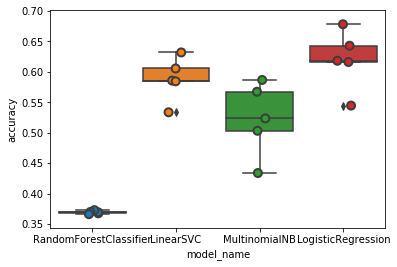

model_name
LinearSVC                 0.588115
LogisticRegression        0.619907
MultinomialNB             0.522812
RandomForestClassifier    0.369123
Name: accuracy, dtype: float64

In [70]:
cv_df = cv_accuracy(XreviewText_tfidf, y)
display_cv_df(cv_df)
cv_df.groupby('model_name').accuracy.mean() 

<b>Nhận Xét:</b> LogisticRegression có độ chính xác cao nhất với 61.99%.MultinomialNB với độ chính xác là 52.28%

## 1.2 Train model với feature summary

In [71]:
X_train, X_test, y_train, y_test = train_test_split(Xsummary_tfidf, y, random_state = 0)
#We call our estimator instance clf, as it is a classifier.
clf = MultinomialNB().fit(X_train, y_train)
summary_balance_accuracy = accuracy_score(y_test, clf.predict(X_test))*100

In [72]:
print('Accuracy of MultinomialNB classifier on test set is {:.2f}%'.format(summary_balance_accuracy))

Accuracy of MultinomialNB classifier on test set is 54.13%


C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


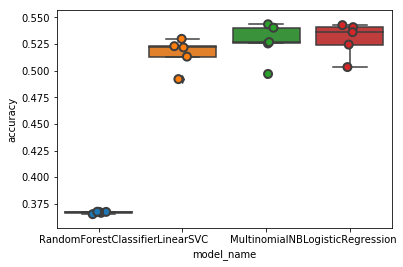

model_name
LinearSVC                 0.515978
LogisticRegression        0.529534
MultinomialNB             0.526629
RandomForestClassifier    0.366810
Name: accuracy, dtype: float64

In [73]:
cv_df = cv_accuracy(Xsummary_tfidf, y)
display_cv_df(cv_df)
cv_df.groupby('model_name').accuracy.mean()

<b>Nhận Xét:</b> LogisticRegression có độ chính xác cao nhất với 52.95%.MultinomialNB với độ chính xác là 52.66%

## 1.3 Train model với kết hợp 2 feature là reviewText và summary

In [74]:
X_train, X_test, y_train, y_test = train_test_split(XreviewText_summary_tfidf, y, random_state = 0)
#We call our estimator instance clf, as it is a classifier.
clf = MultinomialNB().fit(X_train, y_train)
reviewText_summary_balance_accuracy = accuracy_score(y_test, clf.predict(X_test))*100

In [75]:
print('Accuracy of MultinomialNB classifier on test set is {:.2f}%'.format(reviewText_summary_balance_accuracy))

Accuracy of MultinomialNB classifier on test set is 61.83%


C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


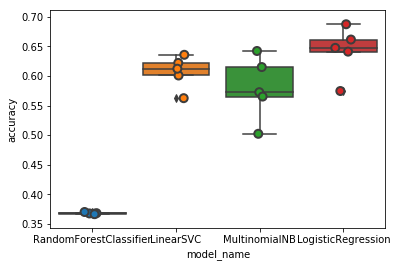

model_name
LinearSVC                 0.606727
LogisticRegression        0.642500
MultinomialNB             0.579508
RandomForestClassifier    0.367886
Name: accuracy, dtype: float64

In [76]:
cv_df = cv_accuracy(XreviewText_summary_tfidf, y)
display_cv_df(cv_df)
cv_df.groupby('model_name').accuracy.mean() 

<b>Nhận Xét:</b> LogisticRegression có độ chính xác cao nhất với 64.25%.MultinomialNB với độ chính xác là 57.95%